# Project 3 - Part 3 (Feature Selection)
## Roman Sielewicz, Imani Mufti, Alek Carlson, Adam Tassabehji, Sharath Reddy
### 2021 April 29

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import ks_2samp
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# packages for google colab
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# getting link and accessing data
# link: shareable link to excel file
link = 'https://drive.google.com/file/d/1ubpDsxO3qLWBFcAVe3E_zd1KlR66b0Hu/view?usp=sharing' 
id = link.split('/')[-2] # id: the drive file identifier
print(id)

1ubpDsxO3qLWBFcAVe3E_zd1KlR66b0Hu


In [5]:
# creating pandas dataframe
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('card_transactions_all_features.csv')  
df = pd.read_csv('card_transactions_all_features.csv')

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

In [6]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merchdescription,Merchstate,Merchzip,Transtype,Amount,Fraud,dow_risk,card_merchant,card_zip,card_state,Cardnum_day_since,Merchnum_day_since,card_merchant_day_since,card_zip_day_since,card_state_day_since,Cardnum_count_0,Cardnum_count_1,Cardnum_count_3,Cardnum_count_7,Cardnum_count_14,Cardnum_count_30,Merchnum_count_0,Merchnum_count_1,Merchnum_count_3,Merchnum_count_7,Merchnum_count_14,Merchnum_count_30,card_merchant_count_0,card_merchant_count_1,card_merchant_count_3,card_merchant_count_7,card_merchant_count_14,card_merchant_count_30,card_zip_count_0,card_zip_count_1,card_zip_count_3,...,card_merchant_mean_13,card_merchant_total_13,card_merchant_mean_17,card_merchant_total_17,card_merchant_mean_114,card_merchant_total_114,card_merchant_mean_130,card_merchant_total_130,card_zip_mean_03,card_zip_total_03,card_zip_mean_07,card_zip_total_07,card_zip_mean_014,card_zip_total_014,card_zip_mean_030,card_zip_total_030,card_zip_mean_13,card_zip_total_13,card_zip_mean_17,card_zip_total_17,card_zip_mean_114,card_zip_total_114,card_zip_mean_130,card_zip_total_130,card_state_mean_03,card_state_total_03,card_state_mean_07,card_state_total_07,card_state_mean_014,card_state_total_014,card_state_mean_030,card_state_total_030,card_state_mean_13,card_state_total_13,card_state_mean_17,card_state_total_17,card_state_mean_114,card_state_total_114,card_state_mean_130,card_state_total_130
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.025994,51421904395509006296254,5.142190e+14,5142190439TN,365.0,365.0,365.0,365.0,365.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,0.025994,514218397361003026333,5.142184e+13,5142183973MA,365.0,365.0,365.0,365.0,365.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,0.025994,51421317214503082993600,5.142132e+14,5142131721MD,365.0,365.0,365.0,365.0,365.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,0.025994,51421484525509006296254,5.142148e+14,5142148452TN,365.0,0.0,365.0,365.0,365.0,1,1,1,1,1,1,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.025994,51421904395509006296254,5.142190e+14,5142190439TN,0.0,0.0,0.0,0.0,0.0,2,2,2,2,2,2,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,...,3.0,3.0,7.0,7.0,14.0,14.0,30.0,30.0,3.0,3.0,7.0,7.0,14.0,14.0,30.0,30.0,3.0,3.0,7.0,7.0,14.0,14.0,30.0,30.0,3.0,3.0,7.0,7.0,14.0,14.0,30.0,30.0,3.0,3.0,7.0,7.0,14.0,14.0,30.0,30.0


In [7]:
feat_sel_df=df[(df.Date>'2010-01-14')&(df.Date<'2010-11-01')].reset_index(drop=True)

In [8]:
feat_sel_df.drop(columns=['Recnum','Cardnum','Date','Merchnum','Merchdescription','Merchstate','Merchzip',\
                     'Transtype','Amount','card_merchant','card_zip','card_state','dow_risk'],inplace=True)

In [9]:
feat_sel_df.head()

,Fraud,Cardnum_day_since,Merchnum_day_since,card_merchant_day_since,card_zip_day_since,card_state_day_since,Cardnum_count_0,Cardnum_count_1,Cardnum_count_3,Cardnum_count_7,Cardnum_count_14,Cardnum_count_30,Merchnum_count_0,Merchnum_count_1,Merchnum_count_3,Merchnum_count_7,Merchnum_count_14,Merchnum_count_30,card_merchant_count_0,card_merchant_count_1,card_merchant_count_3,card_merchant_count_7,card_merchant_count_14,card_merchant_count_30,card_zip_count_0,card_zip_count_1,card_zip_count_3,card_zip_count_7,card_zip_count_14,card_zip_count_30,card_state_count_0,card_state_count_1,card_state_count_3,card_state_count_7,card_state_count_14,card_state_count_30,Cardnum_count_03,Cardnum_count_07,Cardnum_count_014,Cardnum_count_030,...,card_merchant_mean_13,card_merchant_total_13,card_merchant_mean_17,card_merchant_total_17,card_merchant_mean_114,card_merchant_total_114,card_merchant_mean_130,card_merchant_total_130,card_zip_mean_03,card_zip_total_03,card_zip_mean_07,card_zip_total_07,card_zip_mean_014,card_zip_total_014,card_zip_mean_030,card_zip_total_030,card_zip_mean_13,card_zip_total_13,card_zip_mean_17,card_zip_total_17,card_zip_mean_114,card_zip_total_114,card_zip_mean_130,card_zip_total_130,card_state_mean_03,card_state_total_03,card_state_mean_07,card_state_total_07,card_state_mean_014,card_state_total_014,card_state_mean_030,card_state_total_030,card_state_mean_13,card_state_total_13,card_state_mean_17,card_state_total_17,card_state_mean_114,card_state_total_114,card_state_mean_130,card_state_total_130
0,0,1.0,2.0,4.0,4.0,4.0,1,3,7,9,21,21,1,1,5,17,35,35,1,1,1,3,3,3,1,1,1,3,3,3,1,1,1,3,3,3,0.428571,0.777778,0.666667,1.428571,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,1.0,1.0,2.0,2.0,2.0,1,2,34,72,119,119,1,2,111,192,306,306,1,1,32,69,115,115,1,1,33,71,118,118,1,1,33,71,118,118,0.088235,0.097222,0.117647,0.252101,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,1.0,1.0,1.0,1.0,1.0,1,7,14,17,33,33,1,3,3,3,13,13,1,3,3,3,9,9,1,3,3,3,9,9,1,3,4,4,10,10,0.214286,0.411765,0.424242,0.909091,...,3.000000,3.000000,7.000000,7.000000,8.558296,2.139574,18.339205,4.584801,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,3.00000,3.000000,7.000000,7.000000,8.558296,2.139574,18.339205,4.584801,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,2.048904,1.365936,4.780776,3.187184,8.139898,1.808866,17.442639,3.876142
3,0,0.0,0.0,0.0,0.0,0.0,2,3,35,73,120,120,2,3,112,193,307,307,2,2,33,70,116,116,2,2,34,72,119,119,2,2,34,72,119,119,0.171429,0.191781,0.233333,0.500000,...,2.536243,0.079258,6.505903,0.094288,14.093386,0.122551,30.200112,0.262610,2.42492,0.073482,6.364886,0.089646,13.620694,0.11543,29.1872,0.247349,2.42492,0.073482,6.364886,0.089646,13.620694,0.115430,29.187200,0.247349,2.42492,0.073482,6.364886,0.089646,13.620694,0.11543,29.1872,0.247349,2.424920,0.073482,6.364886,0.089646,13.620694,0.115430,29.187200,0.247349
4,0,365.0,3.0,365.0,365.0,365.0,1,1,1,1,1,1,1,1,2,3,5,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3.000000,7.000000,14.000000,30.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
feat_sel_df=feat_sel_df.fillna(0)

**Create top 80 variables using KS and FDR scores**

In [11]:
##adding a random variable
feat_sel_df['random_var']=np.random.uniform(low=0.0,high=1.0,size=len(feat_sel_df))

In [12]:
KSFDR=pd.DataFrame({'Variable':feat_sel_df.columns})
KSFDR.index.names=['Variable_no']
print(KSFDR)

goods=feat_sel_df[feat_sel_df['Fraud']==0]
bads=feat_sel_df[feat_sel_df['Fraud']!=0]
num_bads=len(bads)

                            Variable
Variable_no                         
0                              Fraud
1                  Cardnum_day_since
2                 Merchnum_day_since
3            card_merchant_day_since
4                 card_zip_day_since
...                              ...
392              card_state_mean_114
393             card_state_total_114
394              card_state_mean_130
395             card_state_total_130
396                       random_var

[397 rows x 1 columns]


In [13]:
##create KS Score
i=0
KS=[np.nan for j in range(len(feat_sel_df.columns))]
for col in feat_sel_df.columns:
    KS[i]=ks_2samp(goods[col],bads[col])[0]
    i=i+1
KSFDR['KS']=KS

##Create FDR score
j=0
topRows=int(round(len(feat_sel_df)*0.03))
for col in feat_sel_df.columns:
    if col=='Fraud':
        temp=feat_sel_df[['Fraud']].copy()
    else:
        temp=feat_sel_df[[col,'Fraud']].copy()
    temp0=temp.sort_values(col,ascending=False)
    temp1=temp0.head(topRows)
    temp2=temp0.tail(topRows)
    needed1=temp1.loc[:,'Fraud']
    needed2=temp2.loc[:,'Fraud']
    FDR1=sum(needed1)/num_bads
    FDR2=sum(needed2)/num_bads
    FDRate=np.maximum(FDR1,FDR2)
    KSFDR.loc[j,'FDR']=FDRate
    j=j+1

In [14]:
## sorting by rank ks and fdr score
KSFDR['rank_ks'] = KSFDR['KS'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending = True)

## average 
KSFDR['average_rank'] = (KSFDR['rank_ks'] + KSFDR['rank_FDR']) / 2
KSFDR.sort_values(by=['average_rank'], ascending=False, inplace=True)

##rename 
KSFDR.rename(columns={'FDR':'FDR at 3%'},inplace=True)

In [15]:
##split the final data into train, test and OOT
final_df=df.copy()
final_df.drop(columns=['Recnum','Cardnum','Merchnum','Merchdescription','Merchstate','Merchzip',\
                     'Transtype','Amount','card_merchant','card_zip','card_state','dow_risk'],inplace=True)

In [16]:
train_test=final_df[final_df.Date<'2010-11-01']
fraud_train_test=train_test['Fraud']
train_test.drop(columns=['Date','Fraud'],inplace=True)
OOT=final_df[final_df.Date>='2010-11-01']
fraud_oot=OOT['Fraud']
OOT.drop(columns=['Date','Fraud'],inplace=True)

In [17]:
# data_zs = (data - data.mean()) / data.std()
# train_test_zs=(train_test-train_test.mean())/train_test.std()

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
train_test_zs = sc.fit_transform(train_test)
OOT_zs=sc.transform(OOT)

In [18]:
train_test_zs_final = pd.DataFrame(train_test_zs, columns = train_test.columns)
train_test_zs_final['Fraud']=fraud_train_test
train_test_zs_final=train_test_zs_final.fillna(0)
OOT_zs_final = pd.DataFrame(OOT_zs, columns = OOT.columns)
OOT_zs_final['Fraud']=fraud_oot
OOT_zs_final=OOT_zs_final.fillna(0)

In [ ]:
# train_test=train_test.fillna(0)
# OOT=OOT.fillna(0)

In [19]:
print(f'train test zs final has {train_test_zs_final.shape[0]} rows {train_test_zs_final.shape[1]} columns \
    \n OOT zs final has {OOT_zs_final.shape[0]}rows and {OOT_zs_final.shape[1]}columns')

train test zs final has 83970 rows 396 columns     
 OOT zs final has 12427rows and 396columns


In [20]:
##choose top 80 vars from KSFDR and pass it to wrapper
filter_cols=KSFDR[:80].Variable.values
to_wrapper=train_test_zs_final[filter_cols]

##separate into x and y variables
wrapper_data=to_wrapper[to_wrapper.columns.difference(['Fraud'])]
wrapper_y=to_wrapper['Fraud']


In [21]:
wrapper_y.sum()

880

**Wrapper Methods**

**Using Sequential feature selector**

In [22]:
## Defining fdr-scoring metric to use for sfs
def fdr(classifier,x,y,cutoff=0.03):
  '''calculates fdr for given classifier on dataset x and y with cutoff values'''
  return fdr_prob(y,classifier.predict_proba(x),cutoff)

def fdr_prob(y,y_prob,cutoff=0.03):
  """calculates FDR score using a prob list of predicted y"""
  if len(y_prob.shape)!=1:
    y_prob=y_prob[:,-1:]
  num_fraud=len(y[y==1])
  sorted_prob=np.asarray(sorted(zip(y_prob,y),key= lambda x:x[0],reverse=True))
  cutoff_bin=sorted_prob[0:int(len(y)*cutoff),1:] ##3% cutoff
  return len(cutoff_bin[cutoff_bin==1])/num_fraud

In [23]:
##Used FDR (created above) as the scoring metric 
model=DecisionTreeClassifier(criterion='gini',max_depth=10)
sfs=SFS(model,k_features=30,forward=True,verbose=2,scoring=fdr,cv=0)
sfs.fit(wrapper_data,wrapper_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   47.6s finished

[2021-04-29 01:44:59] Features: 1/30 -- score: 0.7465909090909091[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   57.5s finished

[2021-04-29 01:45:56] Features: 2/30 -- score: 0.8147727272727273[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:  1.1min finished

[2021-04-29 01:47:00] Features: 3/30 -- score: 0.8670454545454546[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(clone_estimator=True, cv=0,
                          estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                           class_weight=None,
                                                           criterion='gini',
                                                           max_depth=10,
                                                           max_features=None,
                                                           max_leaf_nodes=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                                           min_samples_split=2,
                                                           min_weight_fraction_leaf=0.0,
                                                           presort='

In [24]:
sfs_fs=pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [25]:
var_id_from_80=[]
var_name=[]
for i in range(1,len(sfs_fs)+1):
    for j in range(len(sfs_fs['feature_idx'][i])):
        if sfs_fs['feature_idx'][i][j] in var_id_from_80:
            continue
        else:
            var_id_from_80.append(sfs_fs['feature_idx'][i][j])
            var_name.append(sfs_fs['feature_names'][i][j])
sno_var=[i for i in range(1,31)]
final_vars_df=pd.DataFrame({'var_id_from_80':var_id_from_80,'sno_variable':sno_var,'var_name':var_name})

In [ ]:
# final_vars_df.to_csv("/content/drive/MyDrive/top_30_vars.csv",index=False)

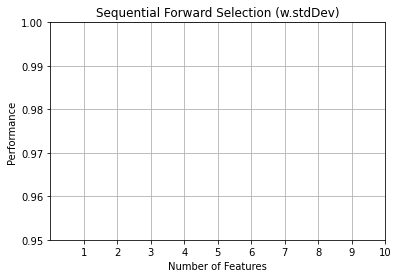

In [27]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig=plot_sfs(sfs.get_metric_dict(),
            kind='std_dev',)
plt.ylim([0.95,1])
plt.xlim(0,10)
plt.title('Sequential Forward Selection (w.stdDev)')
plt.grid()
plt.show()

# import matplotlib.pyplot as plt
# plt.figure(figsize=(8,6))
# x=list(sfs_fs.index[:10])
# y=sfs_fs['cv_scores'][:10]
# plt.plot(x,y)
# plt.ylim([0.95,1])
# plt.xlim(0,10)
# plt.xlabel('Number of Features')
# plt.ylabel('performance')
# plt.title('Sequential Forward Selection (w.stdDev)')
# plt.grid()
# plt.show()





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
final_vars_df

,var_id_from_80,sno_variable,var_name
0,4,1,Cardnum_max_30
1,30,2,card_merchant_max_30
2,26,3,Merchnum_total_3
3,17,4,Cardnum_total_130
4,24,5,Merchnum_mean_7
5,35,6,card_merchant_median_1
6,23,7,Merchnum_mean_3
7,10,8,Cardnum_mean_30
8,32,9,card_merchant_mean_1
9,51,10,card_state_mean_30


In [ ]:
# final_vars_df.to_csv("/content/drive/MyDrive/top_30_vars.csv",index=False)



**Backward selection-to see how much is the diff from forward selection to BS**

In [ ]:
model_bs=DecisionTreeClassifier(criterion='gini',max_depth=10)
sfs_bs=SFS(model,k_features=30,forward=False,verbose=2,scoring=fdr,cv=0)
wrapper_data_x=wrapper_data.values
# wrapper_y_val=
sfs_bs=sfs_bs.fit(wrapper_data_x,wrapper_y,custom_feature_names=wrapper_data.columns)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:  7.0min finished

[2021-04-25 23:50:55] Features: 78/30 -- score: 0.775[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:  6.7min finished

[2021-04-25 23:57:36] Features: 77/30 -- score: 0.7806818181818181[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:  6.6min finished

[2021-04-26 00:04:11] Features: 76/30 -- score: 0.7818181818181819[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of 

In [ ]:
final_vars_df_bs=pd.DataFrame({'idx_from_top_80':sfs_bs.k_feature_idx_,'variable':sfs_bs.k_feature_names_},)

In [ ]:
final_vars_df_bs.to_csv("/content/drive/MyDrive/top_30_vars_bs.csv",index=False)

In [ ]:
final_vars_df_bs

,idx_from_top_80,variable
0,0,Cardnum_max_0
1,1,Cardnum_max_1
2,3,Cardnum_max_3
3,4,Cardnum_max_30
4,5,Cardnum_max_7
5,6,Cardnum_mean_0
6,7,Cardnum_mean_1
7,8,Cardnum_mean_14
8,9,Cardnum_mean_3
9,10,Cardnum_mean_30
